In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial
from scipy.special import erf

In [2]:
# For dealing with very large exponents, stolen from Wikipedia
def exp_by_squaring(x, pows):
    for n in pows:
        if n < 0:
            return exp_by_squaring(1 / x, -n);
        elif n == 0:
            return  1
        elif n == 1:
            return  x
        elif n is even:
            return exp_by_squaring(x * x,  n / 2)
        elif n is odd:
            return x * exp_by_squaring(x * x, (n - 1) / 2)

In [3]:
# probability from Eq. (20) in Epstein
def epstein_spherical_centre(k, delta):
    return (delta/(1+delta)) * exp_by_squaring((k/(1+delta)), k-1) * np.exp(-k/(1+delta)) / factorial(k-1)

# halo mass function from Inman \& Ali-Haimoud (2019):
def inman_ah(n, n_pbh, delta):
    return (n_pbh / n) * epstein_spherical_centre(n, delta)

# expression for N_*, given in Inman \& Ali-Haimoud (2019)
def n_star(delta):
    return 1 / (np.log(1+delta) - (delta / (1+delta)))

# discrete pdf from Press-Schechter formalism, from Hutsi, Veermae & Raidal (2019)
def press_schechter_discrete(n, delta):
    n_s = n_star(delta)
    return erf(np.sqrt(n/n_s)) - erf(np.sqrt((n-1)/n_s))

# continuous pdf from Press-Schechter formalism, from Hutsi, Veermae & Raidal (2019)
def press_schechter_continuous(n, delta):
    n_s = n_star(delta)
    return np.sqrt(n_s/n) * np.exp(-n/n_s)

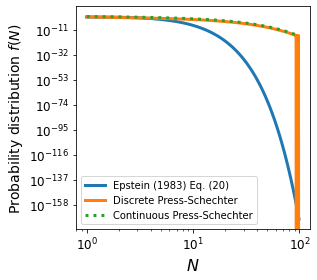

In [4]:
x = np.arange(1, 100)
delta = 1.686

fig = plt.figure(figsize=(4.5,4))
plt.plot(x, epstein_spherical_centre(x, delta), label='Epstein (1983) Eq. (20)', linewidth=3)
#plt.plot(x, inman_ah(x, 1., delta), label='Inman & Ali_Haïmoud (2019) Eq. (46)')
plt.plot(x, press_schechter_discrete(x, delta), label='Discrete Press-Schechter', linewidth=3)
plt.plot(x, press_schechter_continuous(x, delta), label='Continuous Press-Schechter', linewidth=3, linestyle=':')
plt.ylabel('Probability distribution $f(N)$', fontsize=14)
plt.xlabel('$N$', fontsize=16)
plt.xscale('log')
plt.yscale('log')

#plt.xlim(1, 110)
ax = fig.gca()
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

plt.legend()
plt.tight_layout()
plt.savefig('fn.pdf')

/home/ppxmg2/anaconda3/lib/python3.8/site-packages/matplotlib/ticker.py:1106: RuntimeWarning: divide by zero encountered in double_scalars
  coeff = round(x / b ** exponent)
/home/ppxmg2/anaconda3/lib/python3.8/site-packages/matplotlib/ticker.py:1106: RuntimeWarning: divide by zero encountered in double_scalars
  coeff = round(x / b ** exponent)


<Figure size 864x576 with 0 Axes>

/home/ppxmg2/anaconda3/lib/python3.8/site-packages/matplotlib/ticker.py:1106: RuntimeWarning: divide by zero encountered in double_scalars
  coeff = round(x / b ** exponent)


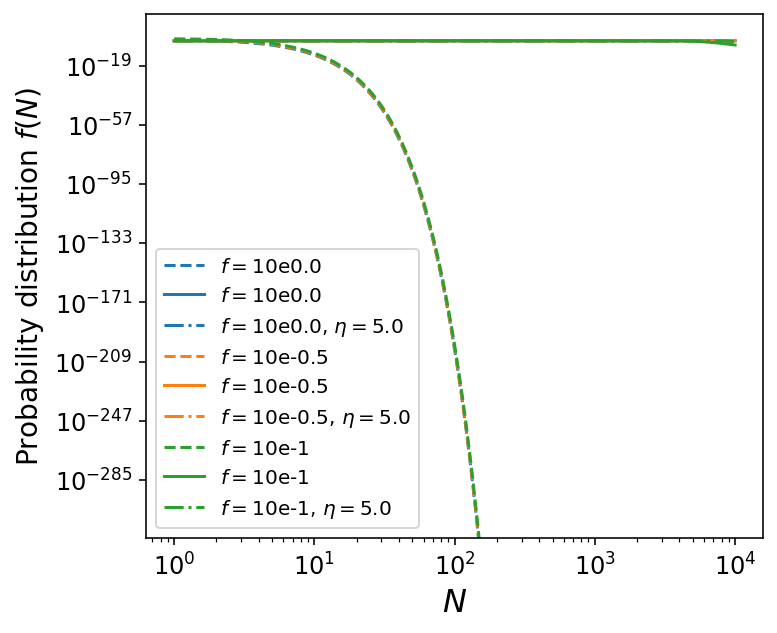

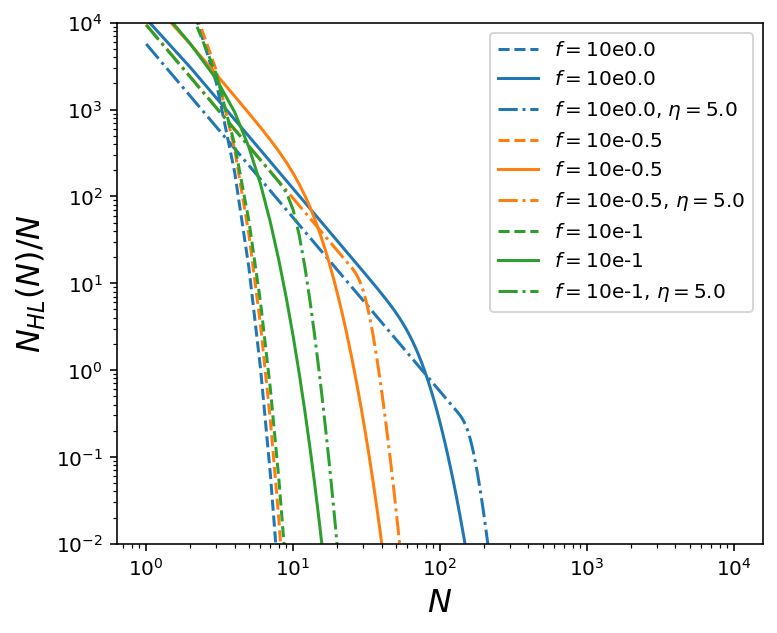

In [46]:
%matplotlib inline
%matplotlib qt

from math import pow
from scipy.stats import poisson

from scipy.optimize import fsolve
plt.clf()

# n is an integer
def power_by_squaring(x, n):
    if n < 0:
        return power_by_squaring(1 / x, -n);
    elif n == 0:
        return 1
    elif n == 1:
        return x
    elif n % 2 == 0:
        return power_by_squaring(x * x,  n / 2)
    else:
        return x * power_by_squaring(x * x, (n - 1) / 2)

# n is an integer    
def powers_onepower(x, n):
    exponents = np.zeros(len(x))
    for i, val in enumerate(x):
        exponents[i] = power_by_squaring(val, n)
    print('exponents ', [exponents])
    return [exponents]

# pows is an array of integers n
def powers(x, pows):
    pows = np.empty(len(pows))
    for i, n in enumerate(pows):
        pows[i] = pow(x, n)
    print('pows ', pows)
    return pows

# implicit equation to solve for kappa:
def f(kappa, params):
    delta, p_t = params
    return np.log(p_t/delta) + 0.5*np.log(2*kappa/np.pi) - kappa

# approximate - eq (38) of Epstein
def interior_prob_spherical_anywhere_approx(k, k_m, kappa):
    return 1 - np.exp(-np.sqrt(k/k_m) * np.exp( - kappa * (k/k_m - 1)))


# Epstein results, approximate assuming large k, small delta
def epstein_spherical_anywhere_approx(k, delta, p_t):
    
    # estimate for the input value of kappa
    est_kappa = np.log(p_t/delta)+1
    
    kappa = fsolve(f, est_kappa, args=([delta, p_t]))
    k_m = 2*kappa / delta **2
    f_ia = interior_prob_spherical_anywhere_approx(k, k_m, est_kappa)
    
    kvals = np.arange(1, 1000)
    f_ea = 1 / np.sum(interior_prob_spherical_anywhere_approx(kvals, k_m, est_kappa))
        
    return f_ia * f_ea

def w(k_vals, delta):
    w = np.empty(len(k_vals))
    for i, k in enumerate(k_vals):
        nu_k = k / (1+delta)
        #print('k = ', k)
        #print(poisson.pmf(int(k-1), nu_k))
        w[i] = poisson.pmf(int(k-1), nu_k)
    return w

def f_ic(k, delta):
    return w(k, delta)

"""
def w(j, nu): # pass j and nu as floats
    print('j=', j)
    print('nu^j =' , np.power(nu, j))
    print('e^-nu = ', np.exp(-nu))
    return power_by_squaring(nu, j) * np.exp(-nu) / factorial(j)
"""

def phi(k, delta):
    nu_k = k/(1+delta)
    return w(k, delta) * (nu_k + k - 1) / (1 + w(k, delta))

# exact - eq (37) of Epstein
def interior_prob_spherical_anywhere(k, delta, p_t):
    #print(k)
    nu_k = k/(1+delta)
    return 1 - (1 - f_ic(k, delta)) * np.exp(-phi(k, delta) * p_t)

# Epstein results
def epstein_spherical_anywhere(k, delta, p_t):
    f_ia = interior_prob_spherical_anywhere(k, delta, p_t)
    
    kvals = np.arange(1, 1000)
    f_ea = 1 / np.sum(interior_prob_spherical_anywhere(kvals, delta, p_t))
        
    return f_ia * f_ea


def epstein_non_spherical_anywhere(k, delta, eta):
    return(epstein_spherical_anywhere(k, delta, (8*eta**3 - 1)))


x = np.arange(1, 10000)
p_t = 7
eta = 5.

pows = (0., -0.5, -1, -3/2, -2)
pows = (0., -0.5, -1)


fig = plt.figure(figsize=(5.5,4.5))

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for i, j in enumerate(pows):
    q = 10**j
    delta = 0.43 / q    # at z=999
    delta = 0.0052 / q  # at z=99
    plt.plot(x, epstein_spherical_centre(x, delta), linestyle = '--', label='$f = 10$e{}'.format(j), color=colors[i])
    plt.plot(x, epstein_spherical_anywhere(x, delta, p_t), label='$f = 10$e{}'.format(j), color=colors[i])
    plt.plot(x, epstein_non_spherical_anywhere(x, delta, eta), linestyle = '-.', label='$f = 10$e{}, $\eta = {}$'.format(j, eta), color=colors[i])
    
    
#plt.ylim(10**(-10), 1.)

plt.ylabel('Probability distribution $f(N)$', fontsize=14)
plt.xlabel('$N$', fontsize=16)
plt.xscale('log')
plt.yscale('log')


ax = fig.gca()
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

plt.legend()
plt.tight_layout()
plt.savefig('fn_epstein.pdf')
plt.show()



fig2 = plt.figure(figsize=(5.5,4.5))

#get colour cycle
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for i, j in enumerate(pows):
    q = 10**j
    delta = 0.43 / q    # at z=999
    #delta = 0.0052 / q  # at z=99
    #print('f', q)
    delta_N = x
    plt.plot(x, (10e5*q/x) * epstein_spherical_centre(x, delta) / delta_N, linestyle = '--', label='$f = 10$e{}'.format(j), color=colors[i])
    plt.plot(x, (10e5*q/x) * epstein_spherical_anywhere(x, delta, p_t) / delta_N, label='$f = 10$e{}'.format(j), color=colors[i])
    plt.plot(x, (10e5*q/x) * epstein_non_spherical_anywhere(x, delta, eta) / delta_N, linestyle = '-.', label='$f = 10$e{}, $\eta = {}$'.format(j, eta), color=colors[i])    
    
plt.ylabel('$N_{HL}(N)/N$', fontsize=16)
plt.xlabel('$N$', fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.ylim(10**(-2), 10**4)

ax = fig.gca()
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

plt.legend()
plt.tight_layout()
plt.savefig('n_epstein_2.pdf')
